In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from keras.optimizers import SGD
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Data Preprocessing***

In [3]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (75, 75))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [4]:
train_dir = "/content/drive/MyDrive/ImageClassification/seg_train/"
test_dir = "/content/drive/MyDrive/ImageClassification/seg_test/"
pred_dir = "/content/drive/MyDrive/ImageClassification/seg_pred/"

In [5]:
print('loading train images')
X_train, y_train = load_data(train_dir)

loading train images


100%|██████████| 316/316 [01:13<00:00,  4.32it/s]


In [6]:
print('loading prediction images')
X_valid, y_valid = load_data(pred_dir)

loading prediction images


100%|██████████| 1110/1110 [04:12<00:00,  4.40it/s]


In [7]:
print('loading test images')
X_test, y_test = load_data(test_dir)


loading test images


100%|██████████| 510/510 [01:54<00:00,  4.47it/s]


In [8]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.fit_transform(y_valid)
y_test = lb.fit_transform(y_test)

# **VGG16**

In [9]:
# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
______________________________________________________________

In [10]:
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

H = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts.h5')

Epoch 1/10
36/36 [==============================] - 22s 364ms/step - loss: 1.4964 - accuracy: 0.3940 - val_loss: 0.6843 - val_accuracy: 0.7105
Epoch 2/10
36/36 [==============================] - 10s 286ms/step - loss: 0.4880 - accuracy: 0.8239 - val_loss: 0.4714 - val_accuracy: 0.8273
Epoch 3/10
36/36 [==============================] - 10s 290ms/step - loss: 0.3525 - accuracy: 0.8704 - val_loss: 0.3198 - val_accuracy: 0.8837
Epoch 4/10
36/36 [==============================] - 11s 296ms/step - loss: 0.2550 - accuracy: 0.9147 - val_loss: 0.3923 - val_accuracy: 0.8539
Epoch 5/10
36/36 [==============================] - 11s 297ms/step - loss: 0.2373 - accuracy: 0.9202 - val_loss: 0.3126 - val_accuracy: 0.8879
Epoch 6/10
36/36 [==============================] - 11s 300ms/step - loss: 0.1575 - accuracy: 0.9458 - val_loss: 0.3400 - val_accuracy: 0.8778
Epoch 7/10
36/36 [==============================] - 11s 303ms/step - loss: 0.1356 - accuracy: 0.9514 - val_loss: 0.3245 - val_accuracy: 0.8843

In [11]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 3s 49ms/step - loss: 0.4589 - accuracy: 0.8647
Test Loss =  0.4588996469974518
Test Accuracy =  0.8646666407585144


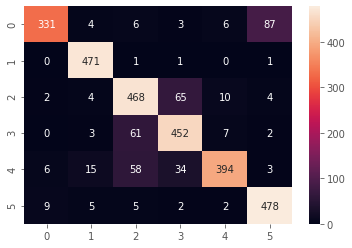

In [14]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix

sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")

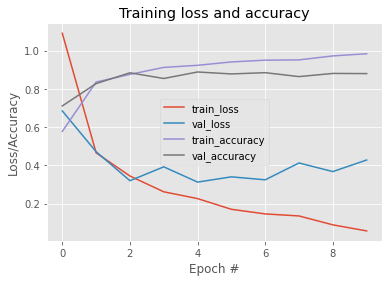

In [13]:
# LEARNING CURVE

N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [15]:
#vgg AUGMENTED


# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

In [16]:

from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, y_train, batch_size=128),
              epochs=10, 
              validation_data=(X_valid, y_valid))


# save the model's trained weights
model.save_weights('vgg_augmented_transfer_trained_wts.h5')


Epoch 1/10
36/36 [==============================] - 15s 387ms/step - loss: 1.5747 - accuracy: 0.3808 - val_loss: 0.8637 - val_accuracy: 0.6420
Epoch 2/10
36/36 [==============================] - 14s 376ms/step - loss: 0.7905 - accuracy: 0.7069 - val_loss: 0.6119 - val_accuracy: 0.7902
Epoch 3/10
36/36 [==============================] - 14s 379ms/step - loss: 0.6112 - accuracy: 0.7797 - val_loss: 0.5814 - val_accuracy: 0.7877
Epoch 4/10
36/36 [==============================] - 14s 376ms/step - loss: 0.5635 - accuracy: 0.7944 - val_loss: 0.4565 - val_accuracy: 0.8368
Epoch 5/10
36/36 [==============================] - 13s 374ms/step - loss: 0.4860 - accuracy: 0.8201 - val_loss: 0.4323 - val_accuracy: 0.8477
Epoch 6/10
36/36 [==============================] - 13s 372ms/step - loss: 0.4836 - accuracy: 0.8322 - val_loss: 0.5117 - val_accuracy: 0.8068
Epoch 7/10
36/36 [==============================] - 13s 370ms/step - loss: 0.4197 - accuracy: 0.8503 - val_loss: 0.4249 - val_accuracy: 0.8401

In [17]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 2s 39ms/step - loss: 0.4749 - accuracy: 0.8227
Test Loss =  0.47486111521720886
Test Accuracy =  0.8226666450500488


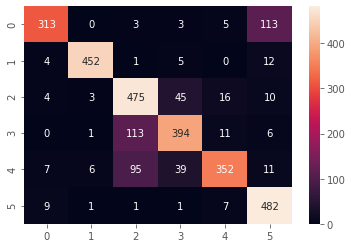

In [18]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")


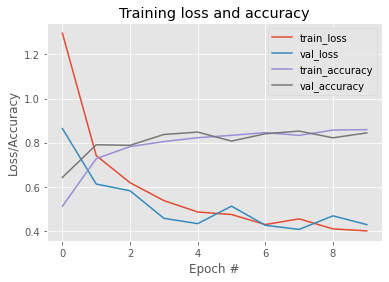

In [19]:
# Lurning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# **InceptionV3**

In [20]:
# load InceptionV3 model without classification layers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# load model
model = InceptionV3(include_top=False,  input_shape=(75,75,3))

# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()


87916544/87910968 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
___________________________

In [21]:
from keras.optimizers import SGD

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

H = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

# save the model's trained weights
model.save_weights('InceptionV3_transfer_trained_wts.h5')

Epoch 1/10
36/36 [==============================] - 16s 241ms/step - loss: 1.8086 - accuracy: 0.2231 - val_loss: 2.2107 - val_accuracy: 0.1931
Epoch 2/10
36/36 [==============================] - 5s 145ms/step - loss: 1.3594 - accuracy: 0.5357 - val_loss: 2.1525 - val_accuracy: 0.2003
Epoch 3/10
36/36 [==============================] - 5s 145ms/step - loss: 0.8795 - accuracy: 0.7009 - val_loss: 2.0640 - val_accuracy: 0.2402
Epoch 4/10
36/36 [==============================] - 5s 146ms/step - loss: 0.6131 - accuracy: 0.7912 - val_loss: 1.5258 - val_accuracy: 0.4484
Epoch 5/10
36/36 [==============================] - 5s 146ms/step - loss: 0.4250 - accuracy: 0.8577 - val_loss: 1.1499 - val_accuracy: 0.5884
Epoch 6/10
36/36 [==============================] - 5s 147ms/step - loss: 0.3324 - accuracy: 0.8959 - val_loss: 0.9759 - val_accuracy: 0.6546
Epoch 7/10
36/36 [==============================] - 5s 148ms/step - loss: 0.2350 - accuracy: 0.9266 - val_loss: 0.9041 - val_accuracy: 0.6929
Epoch

In [22]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 2s 30ms/step - loss: 0.8054 - accuracy: 0.7490
Test Loss =  0.8054097294807434
Test Accuracy =  0.7490000128746033


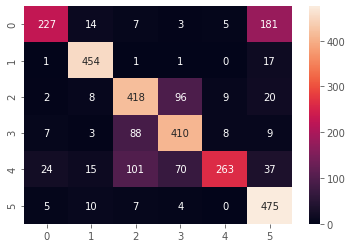

In [23]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")


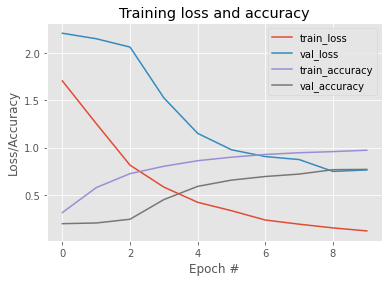

In [24]:
# Learning Curve

N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [25]:
#InceptionV3 AUGMENTED
from keras.preprocessing.image import ImageDataGenerator

# load VGG16 model without classification layers
model = InceptionV3(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 37, 37, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 37, 37, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 37, 37, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [26]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, y_train, batch_size=128),
              epochs=10, 
              validation_data=(X_valid, y_valid))


# save the model's trained weights
model.save_weights('InceptionV3_augmented_transfer_trained_wts.h5')


Epoch 1/10
36/36 [==============================] - 17s 330ms/step - loss: 1.7856 - accuracy: 0.2485 - val_loss: 1.9426 - val_accuracy: 0.2483
Epoch 2/10
36/36 [==============================] - 10s 288ms/step - loss: 1.4593 - accuracy: 0.5095 - val_loss: 1.9660 - val_accuracy: 0.2338
Epoch 3/10
36/36 [==============================] - 10s 287ms/step - loss: 1.1117 - accuracy: 0.6164 - val_loss: 1.7597 - val_accuracy: 0.2616
Epoch 4/10
36/36 [==============================] - 10s 290ms/step - loss: 0.8648 - accuracy: 0.6936 - val_loss: 1.6174 - val_accuracy: 0.3888
Epoch 5/10
36/36 [==============================] - 11s 293ms/step - loss: 0.7538 - accuracy: 0.7360 - val_loss: 1.1423 - val_accuracy: 0.5624
Epoch 6/10
36/36 [==============================] - 10s 290ms/step - loss: 0.6725 - accuracy: 0.7610 - val_loss: 1.2922 - val_accuracy: 0.5988
Epoch 7/10
36/36 [==============================] - 10s 287ms/step - loss: 0.6294 - accuracy: 0.7767 - val_loss: 0.8034 - val_accuracy: 0.6880

In [27]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 1s 22ms/step - loss: 0.7346 - accuracy: 0.7263
Test Loss =  0.7345972657203674
Test Accuracy =  0.7263333201408386


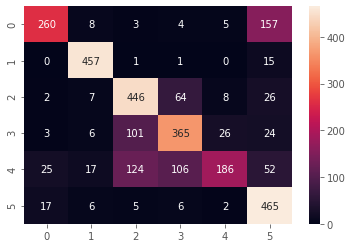

In [28]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")


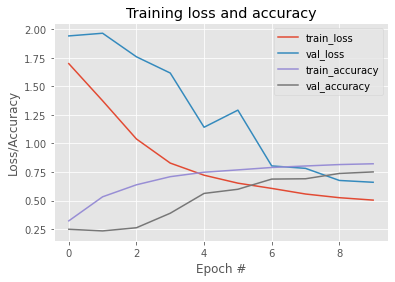

In [29]:
# LearningCurve
import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# ***ResNet50***

In [30]:
# load Resnet50 model without classification layers
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
# load model
model = ResNet50(include_top=False, input_shape=(75,75,3))

# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
___________________________

In [36]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

H = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

# save the model's trained weights
model.save_weights('Resnet50_transfer_trained_wts.h5')

Epoch 1/10
36/36 [==============================] - 15s 311ms/step - loss: 1.6558 - accuracy: 0.5176 - val_loss: 3.5069 - val_accuracy: 0.1876
Epoch 2/10
36/36 [==============================] - 10s 290ms/step - loss: 0.1130 - accuracy: 0.9661 - val_loss: 5.6879 - val_accuracy: 0.1880
Epoch 3/10
36/36 [==============================] - 10s 293ms/step - loss: 0.0272 - accuracy: 0.9962 - val_loss: 9.3678 - val_accuracy: 0.1880
Epoch 4/10
36/36 [==============================] - 11s 294ms/step - loss: 0.0135 - accuracy: 0.9997 - val_loss: 13.4710 - val_accuracy: 0.1880
Epoch 5/10
36/36 [==============================] - 10s 290ms/step - loss: 0.0079 - accuracy: 0.9999 - val_loss: 14.0445 - val_accuracy: 0.1880
Epoch 6/10
36/36 [==============================] - 10s 288ms/step - loss: 0.0064 - accuracy: 0.9999 - val_loss: 17.4701 - val_accuracy: 0.1878
Epoch 7/10
36/36 [==============================] - 10s 287ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 19.1946 - val_accuracy: 0.

In [37]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 2s 34ms/step - loss: 18.5540 - accuracy: 0.1413
Test Loss =  18.553955078125
Test Accuracy =  0.14133332669734955


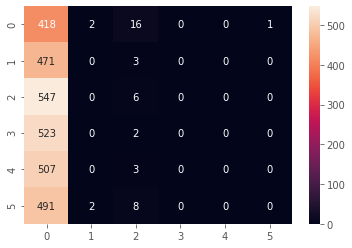

In [38]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")


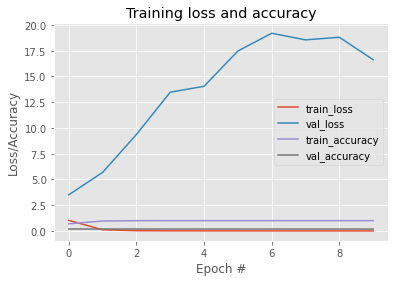

In [39]:
# Learning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [40]:
#resnet AUGMENTED
from keras.preprocessing.image import ImageDataGenerator

# load ResNet50 model without classification layers
model = ResNet50(include_top=False, input_shape=(75, 75, 3) )
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [42]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

HdAug = model.fit(datagen.flow(X_train, y_train, batch_size=128),
              epochs=10, 
              validation_data=(X_valid, y_valid))


# save the model's trained weights
model.save_weights('ResNet50_augmented_transfer_trained_wts.h5')


Epoch 1/10
36/36 [==============================] - 18s 386ms/step - loss: 0.6888 - accuracy: 0.7828 - val_loss: 9.8739 - val_accuracy: 0.2236
Epoch 2/10
36/36 [==============================] - 13s 361ms/step - loss: 0.4283 - accuracy: 0.8471 - val_loss: 4.7827 - val_accuracy: 0.2509
Epoch 3/10
36/36 [==============================] - 13s 361ms/step - loss: 0.3462 - accuracy: 0.8812 - val_loss: 3.5561 - val_accuracy: 0.2946
Epoch 4/10
36/36 [==============================] - 13s 360ms/step - loss: 0.3231 - accuracy: 0.8835 - val_loss: 2.8661 - val_accuracy: 0.3388
Epoch 5/10
36/36 [==============================] - 13s 361ms/step - loss: 0.2897 - accuracy: 0.8951 - val_loss: 2.1333 - val_accuracy: 0.3543
Epoch 6/10
36/36 [==============================] - 13s 360ms/step - loss: 0.3010 - accuracy: 0.8904 - val_loss: 1.8431 - val_accuracy: 0.3697
Epoch 7/10
36/36 [==============================] - 13s 358ms/step - loss: 0.2521 - accuracy: 0.9090 - val_loss: 1.6120 - val_accuracy: 0.4338

In [43]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 2s 33ms/step - loss: 1.0105 - accuracy: 0.6387
Test Loss =  1.0104929208755493
Test Accuracy =  0.6386666893959045


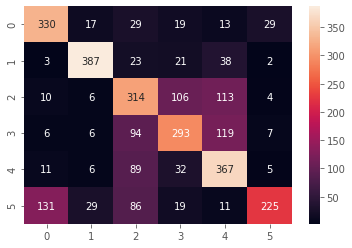

In [44]:
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_true, np.argmax(y_pred, axis=1)),annot=True,fmt="d")


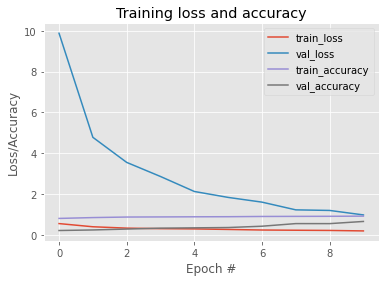

In [45]:
# Learning Curve

import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, HdAug.history['loss'], label='train_loss')
plt.plot(N, HdAug.history['val_loss'], label='val_loss')
plt.plot(N, HdAug.history['accuracy'], label='train_accuracy')
plt.plot(N, HdAug.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()